In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Hoshen-Kopelman Clustering algorithm
#https://en.wikipedia.org/wiki/Hoshen–Kopelman_algorithm

[[2 1 1 1 0 0 2 2 3 1]
 [0 1 1 0 1 1 2 3 3 1]
 [0 0 0 1 2 3 1 1 3 2]
 [0 2 2 1 0 1 3 3 0 3]
 [2 3 2 3 2 1 0 3 1 2]
 [2 3 1 2 0 0 2 0 1 1]
 [1 3 2 1 1 1 3 3 2 2]
 [0 2 0 1 1 1 1 1 3 1]
 [2 2 0 0 1 2 3 3 0 1]
 [3 3 3 2 3 2 3 1 2 1]]
[[ 0.  1.  1.  1.  0.  0.  0.  0.  0.  2.]
 [ 0.  1.  1.  0.  3.  3.  0.  0.  0.  2.]
 [ 0.  0.  0.  4.  0.  0.  5.  5.  0.  0.]
 [ 0.  0.  0.  4.  0.  6.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  7.  0.]
 [ 0.  0.  8.  0.  0.  0.  0.  0.  7.  7.]
 [ 9.  0.  0. 10. 10. 10.  0.  0.  0.  0.]
 [ 0.  0.  0. 10. 10. 10. 10. 10.  0. 11.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  0.  0.  0. 12.  0. 11.]]
[[ 1.  0.  0.  0.  0.  0.  2.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  0.  0.  0.  0.  4.]
 [ 0.  5.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  0.  5.  0.  7.  0.  0.  0.  0.  8.]
 [ 6.  0.  0.  9.  0.  0. 10.  0.  0.  0.]
 [ 0.  0. 11.  0.  0.  0.  0.  0. 12. 12.]
 [ 0. 13.  0.  0.  0.  0.  0.  0.  0.

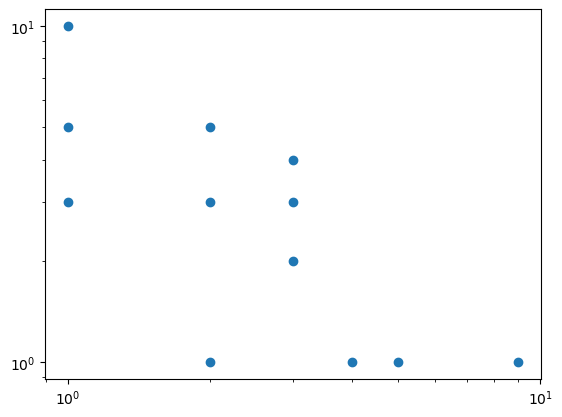

In [3]:
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        print(cluster_ids)
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters

m = np.random.randint(0,4, (10,10), dtype=int)
print(m)
x = run_clustering(m)
print(x)
# Just testing the log plotting
plt.scatter(x.Cluster_size, x.Cluster_count)
plt.yscale('log'), plt.xscale('log')
plt.show()






In [6]:
def power_law(x, a, b):
    return a*np.power(x, b)

pars, cov = curve_fit(f=power_law, ydata=np.log(xx.Cluster_size), xdata=np.log(xx.Cluster_count), p0=[0, 0], bounds=(-np.inf, np.inf))
print(pars, cov)
xx = x[x.cell_type == 1]

np.log(xx.Cluster_count)

NameError: name 'xx' is not defined

In [ ]:
# Fractal Dimension from occupancy rate and radius from centre.
from scipy.optimize import least_squares


def fractal_dimension(m, centre, radius):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    radius = np.zeros(10,2)
    radius[:,0] = range(10) # sets the range to loop over for occupancy
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((centre[0] - i) ** 2 + (centre[1] - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.
    for r in radius[:,0]: 
        current_distance = np.where(distance < radius, 1, 0)
        radius[r,1] = (current_distance * m).sum()
    
    fractal_d = least_squares(np.log(radius[:,1]), np.log(radius[:,0])).x[1] # area is y axis and radius on x, returns coef
    return fractal_d

In [5]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a*np.power(x, b)

pars, cov = curve_fit(f=power_law, xdata=xx.Cluster_size, ydata=xx.Cluster_count, p0=[300, -1.8], bounds=(-np.inf, np.inf))

print(pars)

NameError: name 'xx' is not defined

In [ ]:
m = np.random.randint(0,2, (51,51), dtype=int)
m

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


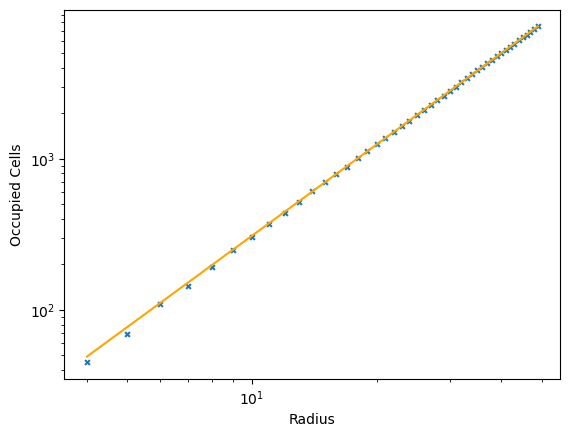

(array([3.03754274, 2.00799205]), array([2.01023138, 1.1031438 ]))

In [42]:
# Fractal Dimension from occupancy rate and radius from centre.
from scipy.optimize import curve_fit

def fractal_dimension(m):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    center = m.shape[0] // 2
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    m = np.where(m > 0, 1, 0)
    
    radius = np.array(range(1, center)) # sets the range to loop over for occupancy
    occupied_cells = np.zeros(center - 1)
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((center - i) ** 2 + (center - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.

    for r in range(len(radius)): # loop through radiuses and chekc which ones are within area and then count cells occupied.
        current_distance = np.where(distance < radius[r], 1, 0)
        area = (current_distance * m).sum()
        occupied_cells[r] = area
        #print((current_distance ).sum(), radius[r])
    pars, cov = curve_fit(f=power_law, xdata=radius, ydata=occupied_cells, p0=[0, 0]) # gives higher weight to large values
    fractal_d = np.polyfit(np.log(radius[15:]), np.log(occupied_cells[15:]), 1) # gives higher weight to small values
    return fractal_d, occupied_cells, radius, pars

def run_fractal_analysis(grid):
    fractal_d, occupied_cells, radius, pars = fractal_dimension(grid)

    plt.scatter(radius[3:], occupied_cells[3:], s = 12, marker = 'x')
    #plt.plot(radius, fractal_d[1] + radius ** fractal_d[0], c = 'orange')
    plt.plot(radius[3:], pars[0] * radius[3:] ** pars[1], c = 'orange')
    plt.xlabel('Radius'), plt.ylabel('Occupied Cells')
    plt.yscale('log'), plt.xscale('log')
    plt.show()
    return pars, fractal_d
    
    
    
run_fractal_analysis(np.random.randint(1,2, (101,101), dtype=int))

In [25]:
np.random.randint(1,2, (51,51), dtype=int)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [40]:
from matplotlib import animation

def gs_animation(frames, track_grid):
    """
    INPUT: frames - how many frames to animate over.
    """
    def init():
        plt.clf()
        plt.imshow(track_grid[0], cmap = cmap, vmin = 0, vmax = 3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        
    # animation function.  This is called sequentially
    def animate(i):
        plt.clf()
        plt.imshow(track_grid[i], cmap = cmap, vmin = 0, vmax = 3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        
    # First set up the figure, the axis, and the plot element we want to animate    
    fig = plt.figure()
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(track_grid[0], cmap = cmap, vmin = 0, vmax = 3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    
    # call the animator. blit=True means only re-draw the parts that have changed.
    # Frames refers to how many images it will use in the animation. 
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=5, blit = False)
    writer = animation.PillowWriter(fps=4, metadata=dict(artist='Me'), bitrate=1800)
    anim.save("test.gif", writer=writer)
    
gs_animation(50, track_grid)

NameError: name 'track_grid' is not defined